## --- Generate text with a recurrent neural network (Pytorch) ---
### (Mostly Read & Run)

The goal is to replicate the (famous) experiment from [Karpathy's blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

To learn to generate text, we train a recurrent neural network to do the following task:

Given a "chunk" of text: `this is random text`

the goal of the network is to predict each character in **`his is random text` ** sequentially given the following sequential input **`this is random tex`**:




## Load text (dataset/input.txt)

Before building training batch, we load the full text in RAM

In [1]:
!wget https://thome.isir.upmc.fr/classes/RITAL/input.txt

--2023-02-17 15:02:14--  https://thome.isir.upmc.fr/classes/RITAL/input.txt
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M   858KB/s    in 1.3s    

2023-02-17 15:02:17 (858 KB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
! pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 4.5 MB/s eta 0:00:00


In [3]:
import unidecode
import string
import random
import re
import torch
import torch.nn as nn

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('./input.txt').read()) #clean text => only ascii
file_len = len(file)
print('file_len =', file_len)


file_len = 1115394


## 2: Helper functions:

We have a text and we want to feed batch of chunks to a neural network:

one chunk  A,B,C,D,E
[input] A,B,C,D -> B,C,D,E [output]

Note: we will use an embedding layer instead of a one-hot encoding scheme.

for this, we have 3 functions:

- One to get a random str chunk of size `chunk_len` : `random_chunk` 
- One to turn a chunk into a tensor of size `(1,chunk_len)` coding for each characters : `char_tensor`
- One to return random input and output chunks of size `(batch_size,chunk_len)` : `random_training_set`




In [4]:
import time, math


#Get a piece of text
def random_chunk(chunk_len):
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(1,len(string)).long()
    for c in range(len(string)):
        tensor[0,c] = all_characters.index(string[c])
    return tensor


#Turn a piece of text in train/test
def random_training_set(chunk_len=200, batch_size=8):
    chunks = [random_chunk(chunk_len) for _ in range(batch_size)]
    inp = torch.cat([char_tensor(chunk[:-1]) for chunk in chunks],dim=0)
    target = torch.cat([char_tensor(chunk[1:]) for chunk in chunks],dim=0)
    
    return inp, target

print(random_training_set(10,4))  ## should return 8 chunks of 10 letters. 

(tensor([[96, 96, 38, 50, 53, 44, 50, 47, 36, 49],
        [60, 50, 53, 46, 77, 96, 44, 94, 25, 27],
        [17, 18, 29, 75, 96, 96, 53, 50, 48, 40],
        [28, 14, 14, 12, 17, 94, 34, 24, 30, 82]]), tensor([[96, 38, 50, 53, 44, 50, 47, 36, 49, 56],
        [50, 53, 46, 77, 96, 44, 94, 25, 27, 18],
        [18, 29, 75, 96, 96, 53, 50, 48, 40, 50],
        [14, 14, 12, 17, 94, 34, 24, 30, 82, 96]]))


## The actual RNN model (only thing to complete):

It should be composed of three distinct modules:

- an [embedding layer](https://pytorch.org/docs/stable/nn.html#embedding) (n_characters, hidden_size)

```
nn.Embedding(len_dic,size_vec)
```
- a [recurrent](https://pytorch.org/docs/stable/nn.html#recurrent-layers) layer (hidden_size, hidden_size)
```
nn.RNN(in_size,out_size) or nn.GRU() or nn.LSTM() => rnn_cell parameter
```
- a [prediction](https://pytorch.org/docs/stable/nn.html#linear) layer (hidden_size, output_size)

```
nn.Linear(in_size,out_size)
```
=> Complete the `init` function code

In [6]:
import torch.nn.functional as f
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, n_char, hidden_size, output_size, n_layers=1,rnn_cell=nn.RNN):
        """
        Create the network
        """
        super(RNN, self).__init__()
        
        self.n_char = n_char
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        #  (batch,chunk_len) -> (batch, chunk_len, hidden_size)  
        self.embed = nn.Embedding(self.n_char,self.hidden_size )  ####
        
        # (batch, chunk_len, hidden_size)  -> (batch, chunk_len, hidden_size)  
        self.rnn = nn.RNN(self.n_char, self.output_size) ####
        
        #(batch, chunk_len, hidden_size) -> (batch, chunk_len, output_size)  
        self.predict = nn.Linear(self.n_char,self.output_size) ####
    
    def forward(self, input):
        """
        batched forward: input is (batch > 1,chunk_len)
        """
        input = self.embed(input)
        output,_  = self.rnn(input)
        output = self.predict(f.tanh(output))
        return output
    
    def forward_seq(self, input,hidden=None):
        """
        not batched forward: input is  (1,chunk_len)
        """
        input = self.embed(input)
        output,hidden  = self.rnn(input.unsqueeze(0),hidden)
        output = self.predict(f.tanh(output))
        return output,hidden


## Text generation function

Sample text from the model

In [7]:
def generate(model,prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_tensor(prime_str).squeeze(0)
    hidden = None
    predicted = prime_str+""
    # Use priming string to "build up" hidden state

    for p in range(len(prime_str)-1):
        _,hidden = model.forward_seq(prime_input[p].unsqueeze(0),hidden)
            
    #print(hidden.size())
    for p in range(predict_len):
        output, hidden = model.forward_seq(prime_input[-1].unsqueeze(0), hidden)
                # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        #print(output_dist)
        top_i = torch.multinomial(output_dist, 1)[0]
        #print(top_i)
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        prime_input = torch.cat([prime_input,char_tensor(predicted_char).squeeze(0)])

    return predicted



## Training loop for net

In [9]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

###Parameters
n_epochs = 20000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 5
lr = 0.005
batch_size = 16
chunk_len = 80

####

model = RNN(n_characters, hidden_size, n_characters, n_layers) #create model
model_optimizer = torch.optim.Adam(model.parameters(), lr=lr) #create Adam optimizer
# Fonction d'erreur utilisée
# Fonction de loss adapté pour la classification
criterion = nn.CrossEntropyLoss() #chose criterion

start = time.time()
all_losses = []
loss_avg = 0


def train(inp, target):
    """
    Train sequence for one chunk:
    """
    #reset gradients
    model_optimizer.zero_grad() 
    
    # predict output
    output = model(inp)
    
    #compute loss
    loss =  criterion(output.view(batch_size*chunk_len,-1), target.view(-1)) 

    #compute gradients and backpropagate
    loss.backward() 
    model_optimizer.step() 

    return loss.data.item() 



for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len,batch_size))  #train on one chunk 
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model,'Wh', 100), '\n')
       


    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


 3s (100 0%) 2.5052]
Whoure wand gast heve avatr whio ghasthe her pl s dat ne ERY:
ANG my fatto my I I be n t ble hend casa 

 6s (200 1%) 2.5544]
Whint, longeresin, s d cer y les, s cond fre;
Iisthen e nd mperas hepu g ved Bucend, llanther's ber y  

 9s (300 1%) 2.4889]
Whicu ho wy h
BEYou mpr thitoulir'ld ofimee her renour terarsthir: hokiled o men son ngh thinieadortig 

 12s (400 2%) 2.4934]
Whate.
Shexn she tathy yof;
MAntousinise RED omye th, pre bly.
Se tooninoutr, ke thay nd he byon, mis  

 15s (500 2%) 2.5407]
Whaton, t coloulyode.
An hand t tors of tcry ged ans; menie se withord wis he
's hes bld bull whin hik 

 18s (600 3%) 2.5143]
Whe he ou arl mungst rd or me t r trillent sthis mize, s.

He we tis m o th cethit f t metit an, t the 

 21s (700 3%) 2.4497]
Whinde ofais pr manou s t, minds thay borefay histh wos
JUKIOfino EThen at ar th anngswis COMusathandi 

 24s (800 4%) 2.4312]
Whirth I Ancoun ond ofr ssisst ngoou foy t tod
Fo s pit h thoffou ssithey ad y man mellfis o

## Visualize loss 

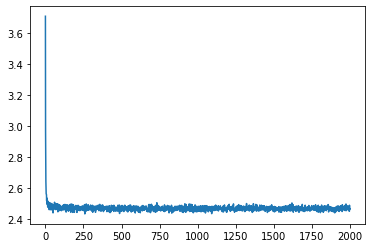

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Try different temperatures

Changing the distribution sharpness has an impact on character sampling:

more or less probable things are sampled

In [11]:
print(generate(model,'T', 200, temperature=1))
print("----")
print(generate(model,'Th', 200, temperature=0.8))
print("----")

print(generate(model,'Th', 200, temperature=0.5))
print("----")

print(generate(model,'Th', 200, temperature=0.3))
print("----")

print(generate(model,'Th', 200, temperature=0.1))

Tebeauk os mont tay fle. sey s,
Wist hasthakime denthe ak, acry tothavis mar'd dye h Wheik wo IUSheay

DEver.
Tharyou ic f brme oonghf r we tho t houaiseghousoortmat
CA:
CAULUMAULUMoninoroulatour! howh
----
Thar!

FRI t s withe I mincke d
Diree youchar.
An Lor s fu he berenthe f irout.
Th mom OLULO:


Yornoryotrere,
AThe bureallathilandou s he thither the t.

SAnisiotedino herse.
Bathoure I bet ages ctoutt
----
The withe m oulllo he w d f wist are n he lllarean he he we thinghethe fou hile n there mereathisthe as be l d anerithe I alld s as the wango o bres y s win hanon thes athe the winge y angar's thand t t
----
The an the the ar t t t and ingo t the in s the lle har the for he of t the s t ithare the the t my a the the t the s t and t the t f at, the the the t the the s the the me the ar the an man bllllor the
----
The the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

### Improving this code:

(a) Tinker with parameters:

- Is it really necessary to have 100 dims character embeddings
- Chunk length can be gradually increased
- Try changing RNN cell type (GRUs - LSTMs)

(b) Add GPU support to go faster


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Rendu prj:
BoW

Obj : Impact de la chaine du traitement sur les résultats.

## Rendu tmes:
Pas trop s'étaler sur les deux derniers

A rendre pour le 19 mars

30%